## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [20]:
import numpy as np# linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
import matplotlib.pyplot as plt
import time
import copy
import math

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score, auc, precision_recall_curve, average_precision_score, f1_score
from PIL import Image

## pytorch libs
import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from IPython.core.display import display
%matplotlib inline
torch.manual_seed(0)
np.random.seed(0)
torch.cuda.empty_cache()
BATCH_SIZE = 16
NUM_EPOCHS = 30

In [21]:
print("torch.cuda.is_available()", torch.cuda.is_available())
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


torch.cuda.is_available() True
PyTorch Version:  1.10.0+cu113
Torchvision Version:  0.11.1+cu113


## Do some early processing of your metadata for easier model training:

In [22]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

def load_xray_data():
    """ load data and preprocess required fields"""
    df = pd.read_csv('data/Data_Entry_2017.csv')

    def convert(x):
        """assume that the first number is incorrect for ages above 110"""
        if x > 110:
            x = int(str(x)[1:-1])
        return x

    # convert ages above 110 to lower ages by assuming and non-random consisting error in the data-collection process.
    df['Patient Age'] = df['Patient Age'].apply(lambda x: convert(x))

    disease_labels_aux = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

    for label in disease_labels_aux:
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)

    all_image_paths = {os.path.basename(x): x for x in
                       glob(os.path.join('data', 'images*', '*', '*.png'))}
    print('Scans found:', len(all_image_paths), ', Total Headers', df.shape[0])
    df['path'] = df['Image Index'].map(all_image_paths.get)

    display(df)
    return df, disease_labels_aux


xray_df, disease_labels = load_xray_data()

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,data\images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,data\images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,data\images_001\images\00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,0,1,0,data\images_012\images\00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,data\images_012\images\00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,data\images_012\images\00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,data\images_012\images\00030804_000.png


In [23]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# please note that this is already done in the function load_xray_data() is lines:
# disease_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))

# for label in disease_labels:
#     df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)


In [24]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Please note that this is already done in the function load_xray_data(), of of the labels corresponds to the 'pneumonia' class.


## Create your training and testing data:

In [25]:
def create_splits_test(df, val_prop, test_prop, class_name):
    ## Either build your own or use a built-in library to split your original dataframe into two sets
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    # split data by patients:
    patient_df = df.groupby(['Patient ID']).first()

    train_patient_df, test_patient_df = train_test_split(patient_df, stratify=patient_df[class_name],
                                                         test_size=test_prop, random_state=0)

    train_patient_df, validation_patient_df = train_test_split(train_patient_df, stratify=train_patient_df[class_name],
                                                         test_size=val_prop, random_state=0)

    train_patient_df = df[df['Patient ID'].isin(train_patient_df.index.values)]
    validation_patient_df = df[df['Patient ID'].isin(validation_patient_df.index.values)]
    test_patient_df = df[df['Patient ID'].isin(test_patient_df.index.values)]

    return train_patient_df, validation_patient_df, test_patient_df


train_data, val_data, test_data = create_splits_test(xray_df, 0.07, 0.013, 'Pneumonia')

# def create_splits(df, val_prop, class_name):
#     ## Either build your own or use a built-in library to split your original dataframe into two sets
#     ## that can be used for training and testing your model
#     ## It's important to consider here how balanced or imbalanced you want each of those sets to be
#     ## for the presence of pneumonia
#
#     # split data by patients:
#     patient_df = df.groupby(['Patient ID']).first()
#
#     train_patient_df, validation_patient_df = train_test_split(patient_df, stratify=patient_df[class_name],
#                                                          test_size=val_prop, random_state=0)
#
#     train_patient_df = df[df['Patient ID'].isin(train_patient_df.index.values)]
#     validation_patient_df = df[df['Patient ID'].isin(validation_patient_df.index.values)]
#
#     return train_patient_df, validation_patient_df


#train_data, val_data = create_splits(xray_df, 0.3, 'Pneumonia')

print('train data, n = {}({}% of the data)'.format(len(train_data), round(len(train_data) / len(xray_df) * 100, 2)))
print('validation, n = {}({}% of the data)'.format(len(val_data), round(len(val_data) / len(xray_df) * 100, 2)))
print('test, n = {}({}% of the data)'.format(len(test_data), round(len(test_data) / len(xray_df) * 100, 2)))

print('prop. pneumonia train data: ' + str(round(train_data['Pneumonia'].sum() / len(train_data), 4)))
print('prop. pneumonia validation data: ' + str(round(val_data['Pneumonia'].sum() / len(val_data), 4)))
print('prop. pneumonia test data: ' + str(round(test_data['Pneumonia'].sum() / len(test_data), 4)))

train data, n = 102633(91.54% of the data)
validation, n = 7800(6.96% of the data)
test, n = 1687(1.5% of the data)
prop. pneumonia train data: 0.0126
prop. pneumonia validation data: 0.0132
prop. pneumonia test data: 0.0184


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [26]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None):
        self.data_frame = df
        self.transforms = transforms
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        row = self.data_frame.iloc[index]

        address = row['path']

        x = Image.open(address).convert('RGB')

        vec = np.array(row['Pneumonia'], dtype=float)
        y = torch.LongTensor(vec)

        if self.transforms:
            x = self.transforms(x)
        return x, y


def my_image_augmentation():
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data

    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    transformations = transforms.Compose([  # transforms.ToPILImage(),
        # transforms.CenterCrop(224),  #
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ToTensor(),
        # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8,
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    return transformations


def make_train_gen(trainset, batch_size, transformations, use_sampler=False):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:

    #     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df,
    #                                          directory=None,
    #                                          x_col = ,
    #                                          y_col = ,
    #                                          class_mode = 'binary',
    #                                          target_size = ,
    #                                          batch_size =
    #                                          )
    train_gen = ImageDataset(trainset, transformations)
    if use_sampler:
        #class_weights = [train_data['Pneumonia'].size/(train_data['Pneumonia'] == 0).sum(),train_data['Pneumonia'].size/train_data['Pneumonia'].sum()]
        class_sample_count = np.unique(trainset['Pneumonia'].values, return_counts=True)[1]
        weight = 1. / class_sample_count
        samples_weight = weight[trainset['Pneumonia'].values]
        samples_weight = torch.from_numpy(samples_weight)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
        trainloader = DataLoader(dataset=train_gen, batch_size=batch_size, sampler=sampler)
    else:
        trainloader = DataLoader(dataset=train_gen, batch_size=batch_size, shuffle=True)

    return trainloader


def make_val_gen(valset, batch_size,use_sampler=False):
    #     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data,
    #                                              directory=None,
    #                                              x_col = ,
    #                                              y_col = ',
    #                                              class_mode = 'binary',
    #                                              target_size = ,
    #                                              batch_size = )

    transformations = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    val_gen = ImageDataset(valset, transformations)
    if use_sampler:
        class_sample_count = np.unique(valset['Pneumonia'].values, return_counts=True)[1]
        weight = 1. / class_sample_count
        samples_weight = weight[valset['Pneumonia'].values]
        samples_weight = torch.from_numpy(samples_weight)
        sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))
        valloader = DataLoader(dataset=val_gen, batch_size=batch_size, shuffle=False, sampler=sampler)
    else:
        valloader = DataLoader(dataset=val_gen, batch_size=batch_size, shuffle=False)

    return valloader


In [27]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(val_data, BATCH_SIZE, use_sampler=False)
#valX, valY = next(iter(val_gen))   

In [28]:
train_gen = make_train_gen(train_data, BATCH_SIZE, my_image_augmentation(), use_sampler=False)
# trainX, trainY = next(iter(train_gen))   

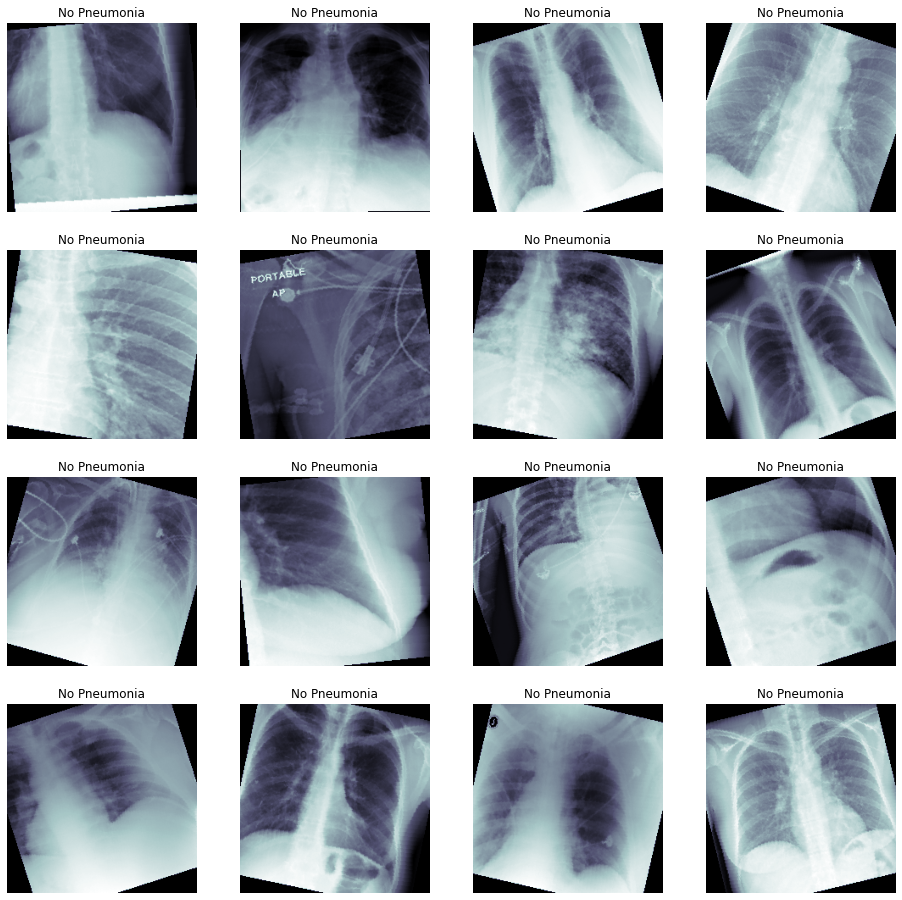

In [29]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(iter(train_gen))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[0,:,:], cmap = 'bone')
    if c_y == 1:
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [30]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    return model

In [31]:
class PneumoNet(nn.Module):
    def __init__(self, out_size):
        super(PneumoNet, self).__init__()
        self.densenet121 = load_pretrained_model()

        num_features = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Linear(num_features, out_size, bias=True)

    def forward(self, x):
        x = self.densenet121(x)
        features = self.densenet121.classifier
        return x, features

def build_my_model():
    
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model,
    # you want to freeze before you compile
    
    # also make sure you set your optimizer, loss function, and metrics to monitor

    return PneumoNet(2).to(device)

model = build_my_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 10)

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your model
## to output class activation maps to aid in clinical interpretation of your model's results

In [32]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code.
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Please note I've implemented the checkpoint and the early stopping in the next function named "train_model"


In [33]:
def accuracy(preds, labels):
    # _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def print_metrics(phase, batch_number, total_batches, loss, acc, auc, prcore, f1score):
    print("\r{} batch {}/{}; loss {:.4f}; acc {:.4f}; auc {:.4f}; prscore {:.4f}, f1score {:.4f}".format(phase, batch_number, total_batches,
                                                                                     loss, acc,
                                                                                     auc, prcore,
                                                                                     f1score))


def train_model(dnn_model, model_criterion, model_optimizer, scheduler, num_epochs=10, patience=10):


    since = time.time()
    best_model_wts = copy.deepcopy(dnn_model.state_dict())
    best_acc = 0.0

    val_epoch_list = []
    val_iteration_list = []
    train_epoch_list = []
    train_iteration_list = []

    train_avg_loss_list = []
    train_avg_acc_list = []
    train_avg_auc_list = []
    train_avg_prscore_list = []
    train_avg_f1score_list = []

    val_avg_loss_list = []
    val_avg_acc_list = []
    val_avg_auc_list = []
    val_avg_prscore_list = []
    val_avg_f1score_list = []

    train_batches_size = len(train_gen)
    val_batches_size = len(val_gen)

    patience_aux = 0

    softmax = nn.Softmax(dim=1)

    for epoch in range(num_epochs):

        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 40)

        loss_train = 0
        acc_train = 0
        prscore_train = 0
        f1score_train = 0
        auc_train = 0

        loss_val = 0
        acc_val = 0
        prscore_val = 0
        f1score_val = 0
        auc_val = 0

        train_auc_count = 0

        dnn_model.train(True)

        for i, data in enumerate(train_gen):

            if i % 100 == 0:

                if i > 0:
                    avg_loss_aux = loss_train / (i+1)
                    avg_acc_aux = acc_train / (i+1)
                    avg_auc_aux = auc_train / train_auc_count
                    avg_prscore_aux = prscore_train / train_auc_count
                    avg_f1score_aux = f1score_train / train_auc_count
                    print_metrics('Train', i, train_batches_size, avg_loss_aux, avg_acc_aux, avg_auc_aux, avg_prscore_aux, avg_f1score_aux)
                    train_avg_loss_list.append(avg_loss_aux.cpu().detach().numpy())
                    train_avg_acc_list.append(avg_acc_aux.cpu().detach().numpy())
                    train_avg_prscore_list.append(avg_prscore_aux)
                    train_avg_f1score_list.append(avg_f1score_aux)
                    train_avg_auc_list.append(avg_auc_aux)
                    train_epoch_list.append(epoch)
                    train_iteration_list.append(i)

            # Use half training dataset
            # if i >= 101:
            #     break

            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print("\rTrain class0 {}; class1 {} ".format(sum(labels == 0), sum(labels)))
            optimizer.zero_grad()

            outputs = dnn_model(inputs)

            _, preds = torch.max(outputs[0], 1)
            loss = model_criterion(outputs[0], labels)

            loss.backward()
            model_optimizer.step()

            loss_train += loss.item()
            acc_train += accuracy(preds, labels)

            labels_cpu = labels.cpu().detach().numpy()
            prob_cpu = softmax(outputs[0]).cpu().detach().numpy()
            prob_cpu = prob_cpu[:, 1]
            preds_cpu = preds.cpu().detach().numpy()


            if (len(np.unique(labels_cpu)) > 1):
                train_auc_count = train_auc_count + 1
                f1score_train += f1_score(labels_cpu, preds_cpu)
                prscore_train += average_precision_score(labels_cpu, prob_cpu)
                auc_train += roc_auc_score(labels_cpu, prob_cpu)


            scheduler.step()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()

        train_avg_loss = loss_train / train_batches_size
        train_avg_acc = acc_train / train_batches_size
        train_avg_auc = auc_train / train_auc_count
        train_avg_prscore = prscore_train / train_auc_count
        train_avg_f1score = f1score_train / train_auc_count

        train_avg_loss_list.append(train_avg_loss.cpu().detach().numpy())
        train_avg_acc_list.append(train_avg_acc.cpu().detach().numpy())
        train_avg_prscore_list.append(train_avg_prscore)
        train_avg_f1score_list.append(train_avg_f1score)
        train_avg_auc_list.append(train_avg_auc)
        train_epoch_list.append(epoch)
        train_iteration_list.append(i)
        dnn_model.train(False)
        dnn_model.eval()

        val_auc_count = 0

        with torch.no_grad():
            for i, data in enumerate(val_gen):
                if i % 100 == 0:
                    if i > 0:
                        avg_loss_val_aux = loss_val / (i+1)
                        avg_acc_val_aux = acc_val / (i+1)
                        avg_auc_val_aux = auc_val / (val_auc_count)
                        avg_prscore_val_aux = prscore_train / val_auc_count
                        avg_f1score_val_aux = f1score_train / val_auc_count
                        print_metrics('Validation', i, val_batches_size, avg_loss_val_aux, avg_acc_val_aux, avg_auc_val_aux, avg_prscore_val_aux, avg_f1score_val_aux)
                        val_avg_loss_list.append(avg_loss_val_aux.cpu().detach().numpy())
                        val_avg_acc_list.append(avg_acc_val_aux.cpu().detach().numpy())
                        val_avg_prscore_list.append(avg_prscore_val_aux)
                        val_avg_f1score_list.append(avg_f1score_val_aux)
                        val_avg_auc_list.append(avg_f1score_val_aux)
                        val_epoch_list.append(epoch)
                        val_iteration_list.append(i)
                # if i >= 101:
                #     break

                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                print("\rValidation class0 {}; class1 {} ".format(sum(labels == 0), sum(labels)))

                optimizer.zero_grad()

                outputs = dnn_model(inputs)

                _, preds = torch.max(outputs[0], 1)
                loss = criterion(outputs[0], labels)

                loss_val += loss.item()
                acc_val += accuracy(preds, labels)
                labels_cpu = labels.cpu().detach().numpy()
                prob_cpu = softmax(outputs[0]).cpu().detach().numpy()
                prob_cpu = prob_cpu[:, 1]
                preds_cpu = preds.cpu().detach().numpy()

                if(len(np.unique(labels_cpu))>1):
                    val_auc_count = val_auc_count+1
                    auc_val += roc_auc_score(labels_cpu, prob_cpu)
                    f1score_val += f1_score(labels_cpu, preds_cpu)
                    prscore_val += average_precision_score(labels_cpu, prob_cpu)

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()

        val_avg_loss = loss_val / val_batches_size
        val_avg_acc = acc_val / val_batches_size
        val_avg_auc = auc_val / val_auc_count
        val_avg_prscore = prscore_val / val_auc_count
        val_avg_f1score = f1score_val / val_auc_count


        val_avg_loss_list.append(val_avg_loss.cpu().detach().numpy())
        val_avg_acc_list.append(val_avg_acc.cpu().detach().numpy())
        val_avg_prscore_list.append(val_avg_prscore)
        val_avg_f1score_list.append(val_avg_f1score)
        val_avg_auc_list.append(val_avg_auc)
        val_epoch_list.append(epoch)
        val_iteration_list.append(i)

        print("\rEpoch {}, Training loss/acc/auc/prscore/f1score: {:.4f} / {:.4f} / {:.4f} / {:.4f} / {:.4f}; "
              "Validation loss/acc/auc/prscore/f1score: {:.4f} / {:.4f} / {:.4f} / {:.4f} / {:.4f}".
              format(epoch, train_avg_loss, train_avg_acc, train_avg_auc, train_avg_prscore, train_avg_f1score,
                     val_avg_loss, val_avg_acc, val_avg_auc, val_avg_prscore, val_avg_f1score))

        if val_avg_acc > best_acc:
            print("val_binary_accuracy improved from {}".format(best_acc))
            print('-' * 40)
            best_acc = val_avg_acc
            best_model_wts = copy.deepcopy(dnn_model.state_dict())
            torch.save(dnn_model.state_dict(), 'PneumoDensenet_weights_checkpoint_imbalanced_{}.h5'.format(epoch))

        else:
            patience_aux = patience_aux+1
            print("val_binary_accuracy did not improve from {}".format(best_acc))
            print('-' * 40)
            # if patience_aux > patience:
            #     break

    elapsed_time = time.time() - since
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))

    dnn_model.load_state_dict(best_model_wts)

    history_val = {}
    history_val['epoch'] = train_epoch_list
    history_val['iteration'] = train_iteration_list
    history_val['avg_loss'] = train_avg_loss_list
    history_val['avg_acc']  = train_avg_acc_list
    history_val['avg_auc'] = train_avg_auc_list
    history_val['avg_prscore'] = train_avg_prscore_list
    history_val['avg_f1score'] = train_avg_f1score_list

    history_train = {}
    history_train['epoch'] = train_epoch_list
    history_train['iteration'] = train_iteration_list
    history_train['avg_loss']   = val_avg_loss_list
    history_train['avg_acc']    = val_avg_acc_list
    history_train['avg_auc'] = val_avg_auc_list
    history_train['avg_prscore'] = val_avg_prscore_list
    history_train['avg_f1score'] = val_avg_f1score_list

    return dnn_model, history_train, history_val


### Start training!

In [12]:
## train your model
# Todo
# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)
final_model, history_train, history_val = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=NUM_EPOCHS)
torch.save(final_model.state_dict(), 'PneumoDensenet121_weights_tests_imbalance_{}_{}.h5'.format(BATCH_SIZE, NUM_EPOCHS))
history_val_df = pd.DataFrame(history_val)
history_val_df.to_csv('PneumoDensenet121_history_val_tests_imbalance_{}_{}.csv'.format(BATCH_SIZE,NUM_EPOCHS))
history_train_df = pd.DataFrame(history_train)
history_train_df.to_csv('PneumoDensenet121_history_train_tests_imbalance_{}_{}.csv'.format(BATCH_SIZE,NUM_EPOCHS))

Epoch 0/1
----------
Training batch 100/1133; mean_loss 0.006034227088093758, mean_acc 0.9702970385551453 
Epoch 0, Training mean_loss/acc: 0.0005 / 0.0866; Validation mean_loss/acc: 0.0036 / 0.7238
val_binary_accuracy improved from 0.0
----------------------------------------
Training completed in 1m 49s
Best acc: 0.7238


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [48]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model = PneumoNet(2).to(device)
test_gen = make_val_gen(test_data, 10)
image, label = next(iter(test_gen))
image = image.cuda()
softmax = nn.Softmax(dim=1)
files=['server3/PneumoDensenet121_weights_tests_balance_100_30.pt',
       'server3/PneumoDensenet121_weights_tests_balance_20_30.pt',
      'server4/PneumoDensenet121_weights_tests_imbalance_100_30.pt',
      'server4/PneumoDensenet121_weights_tests_imbalance_16_30.pt']
for f in files:
    print(f)
    my_model.load_state_dict(torch.load(f,map_location='cuda:0'))
    my_model.eval()
    pred_Y = []
    with torch.no_grad():
        predicted, _ = my_model(image)
        aux=softmax(predicted).cpu().detach().numpy()
        pred_Y.append(np.argmax(aux,axis=1))
        ACC=np.sum(pred==label)/len(label)
    # predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{pred_Y}", Actual: "{label}", ACC: "{ACC}"')
    #pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

server3/PneumoDensenet121_weights_tests_balance_100_30.pt
Predicted: "[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)]", Actual: "tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])", ACC: "0.0"
server3/PneumoDensenet121_weights_tests_balance_20_30.pt
Predicted: "[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)]", Actual: "tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])", ACC: "0.0"
server4/PneumoDensenet121_weights_tests_imbalance_100_30.pt
Predicted: "[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]", Actual: "tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])", ACC: "0.0"
server4/PneumoDensenet121_weights_tests_imbalance_16_30.pt
Predicted: "[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]", Actual: "tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])", ACC: "0.0"


In [56]:
def plot_auc(t_y, p_y):

    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    auc_pneumonia_aux = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = "Pneumonia AUC:{}".format(round(auc_pneumonia_aux,2)))
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


    return auc_pneumonia, fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 
# TPR - True Positive Rate
# PPV - Positive Predictive Value

def plot_precision_recall_curve(t_y, p_y):

    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    average_precision_score_aux = average_precision_score(t_y, p_y)

    plt.plot(recall, precision, label = "average_precision_score AUC:{}".format(round(average_precision_score_aux,2)))
    plt.legend()
    plt.xlabel('Recall (TPR)')
    plt.ylabel('Precision (PPV)')


    return average_precision_score_aux, precision, recall, thresholds

#Also consider plotting the history of your model training:

def plot_f1score_curve(t_y, p_y):

    f1score_list = []
    thresh_list = []
    best_f1 = 0
    best_thres = None

    for t in np.arange(0.0, 1, 0.02):

        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)

        if best_f1 < f1:

            best_f1 = f1
            best_thres = t

        f1score_list.append(f1)
        thresh_list.append(t)

    plt.plot(thresh_list, f1score_list,
              label = 'Pneumonia optimal F1 Score:{} with threshold {})'.format(round(best_f1,4), round(best_thres,4)))
    plt.legend()
    plt.xlabel('thresh')
    plt.ylabel('f1')

    return best_thres, f1score_list, thresh_list


def plot_history(history_train_df,history_val_df,ax=None,title=None):

    if ax is None:
        fig_aux, ax = plt.subplot(2, 2)
    #iterations=list(range(0,len(history_var['train_avg_loss'])))
    ax[0,0].plot(history_train_df['avg_loss'], label = 'Train Loss')
    ax[0,0].plot(history_train_df['avg_acc'], label = 'Train ACC')
    ax[0,0].plot(history_val_df['avg_loss'], label = 'Val Loss')
    ax[0,0].plot(history_val_df['avg_acc'], label = 'Val ACC')
    
    if title is None:
        ax[0,0].set_title('Avg Loss/ACC')
    else:
        ax[0,0].set_title(title)
    
    ax[0,0].legend()
    ax[0,0].set_xlabel('iterations')
    ax[0,0].set_ylabel('Loss/ACC')
    ################################################################
    ax[0,1].plot(history_train_df['avg_auc'], label = 'Train AUC')
    ax[0,1].plot(history_val_df['avg_auc'], label = 'Val AUC')
    
    if title is None:
        ax[0,1].set_title('Avg AUC')
    else:
        ax[0,1].set_title(title)
    
    ax[0,1].legend()
    ax[0,1].set_xlabel('iterations')
    ax[0,1].set_ylabel('Avg AUC')
    
    ################################################################
    ax[1,0].plot(history_train_df['avg_prscore'], label = 'Train PR score')
    ax[1,0].plot(history_val_df['avg_prscore'], label = 'Val PR score')
    
    if title is None:
        ax[1,0].set_title('Avg Precision/Recall score')
    else:
        ax[1,0].set_title(title)
    
    ax[1,0].legend()
    ax[1,0].set_xlabel('iterations')
    ax[1,0].set_ylabel('Avg PR score')
    
    ################################################################
    ax[1,1].plot(history_train_df['avg_f1score'], label = 'Train f1score')
    ax[1,1].plot(history_val_df['avg_f1score'], label = 'Val f1score')
    
    if title is None:
        ax[1,1].set_title('Avg avg_f1score')
    else:
        ax[1,1].set_title(title)
    
    ax[1,1].legend()
    ax[1,1].set_xlabel('iterations')
    ax[1,1].set_ylabel('Avg f1score')

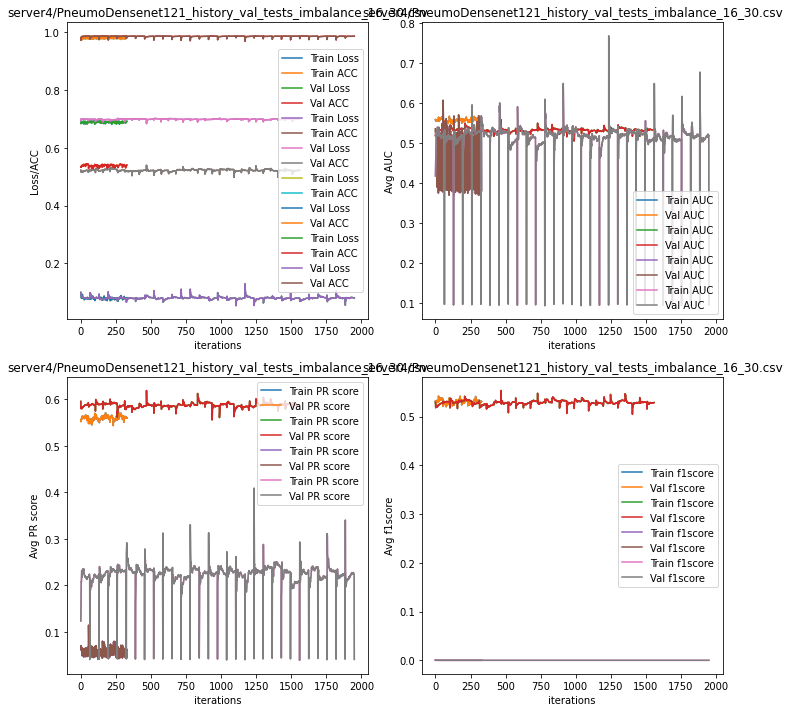

In [62]:
## plot history
files_history_train=['server3/PneumoDensenet121_history_val_tests_balance_100_30.csv',
       'server3/PneumoDensenet121_history_val_tests_balance_20_30.csv',
      'server4/PneumoDensenet121_history_val_tests_imbalance_100_30.csv',
      'server4/PneumoDensenet121_history_val_tests_imbalance_16_30.csv']
files_history_val=files_history_train
fig_aux, ax = plt.subplots(2, 2,figsize=(10,10))
for i in range(len(files_history_train)):
    history_train_df = pd.read_csv(files_history_train[i])
    history_val_df = pd.read_csv(files_history_val[i])
    
    plot_history(history_train_df,history_val_df,ax=ax,title=files_history_train[i])
    plt.tight_layout()

plt.show()

In [15]:
## plot figures
auc_pneumonia, fpr_pneumonia, tpr_pneumonia, _ = plot_auc(valY_test, pred_Y)
average_precision_score_pneumonia, precision_pneumonia, recall_pneumonia, thresholds_pneumonia = plot_precision_recall_curve(valY_test, pred_Y)
best_threshold_pneumonia, f1score_list_pneumonia, thresh_list_pneumonia = plot_f1score_curve(valY_test, pred_Y)


NameError: name 'pred_Y' is not defined

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [14]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

threshold = 0###
idx = (np.abs(thresholds_pneumonia - threshold)).argmin()

precision_optimal = precision_pneumonia[idx]
recall_optimal = recall_pneumonia[idx]
threshold_optimal = thresholds_pneumonia[idx]
def  f1_score_pr(precision,recall):
    return 2*(precision*recall)/(precision+recall)
f1score_optimal = f1_score_pr(precision_pneumonia[idx],recall_pneumonia[idx])

print('Optimal Threshold is: %.4f'%threshold_optimal)
print('Optimal Precision: %.4f'%precision_optimal)
print('Optimal Recall is: %.4f'%recall_optimal)
print('Optimal F1 Score is: %.4f'%f1score_optimal)
YOUR_THRESHOLD=threshold_optimal

NameError: name 'thresholds_pneumonia' is not defined

In [ ]:
## Let's look at some examples of predicted v. true with our best model: 

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX_test[0:100], valY_test[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:
# in pytorch it's not possible to save just the architecture using the core SDK.
# However, it's possible to save both the architecture and weights using the next command:
torch.save(my_model, 'my_model.pt')

# model_json = my_model.to_json()
# with open("my_model.json", "w") as json_file:
#     json_file.write(model_json)